We compare the standard preprocessing method with the final autoencoder (with engineered loss function) 

**Loading the data**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers
import pandas as pd

In [2]:
path_data = r"\\z-sv-dfsroot\dfsroot\project\agzigman\MIRA Anaylzer - Eval\L4L_all_samples\Serum" # path to the folder with measurements
df = pd.read_excel(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\LuCa_VS_NSR.xlsx")

vec = pd.read_csv(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\sample.txt", sep='\t')
vec = vec.X
vec_ = vec.to_list()

In [3]:
###---###---###  Import  ###---###---###
import pandas as pd
import os.path 
import json

path_data = r"\\z-sv-dfsroot\dfsroot\project\agzigman\MIRA Anaylzer - Eval\L4L_all_samples\Serum" # path to the folder with measurements
df = pd.read_excel(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\LuCa_VS_NSR.xlsx")

cancer = df[df.cancer_status==1]
healthy = df[df.cancer_status==0]
list_Healthy = healthy.filename  
list_Cancer = cancer.filename

df_Healthy = pd.DataFrame()
for name in list_Healthy:
    json_file = os.path.join(path_data, str(name))
    json_file = json_file + '.json'
    if os.path.exists(json_file):
        with open(json_file) as f:
            data = json.load(f)
        data = pd.DataFrame(np.flip(data['AB Data']))
        frame_Healthy = pd.DataFrame(data).T
        frame_Healthy['filename'] = os.path.basename(json_file)
        df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)

df_Cancer = pd.DataFrame()
for name in list_Cancer:
    json_file = os.path.join(path_data, str(name))
    json_file = json_file + '.json'
    if os.path.exists(json_file):
        with open(json_file) as f:
            data = json.load(f)
        data = pd.DataFrame(np.flip(data['AB Data']))
        frame_Cancer = pd.DataFrame(data).T
        frame_Cancer['filename'] = os.path.basename(json_file)
        df_Cancer = df_Cancer.append(frame_Cancer, ignore_index=True)

# df_Healthy = pd.DataFrame()
# for name in list_Healthy:
#     csv = os.path.join(path_data, str(name))
#     vec = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[0])[0].values
#     frame_Healthy = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[1]).T
#     frame_Healthy['filename'] = os.path.basename(csv)
#     df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
#
# df_Cancer = pd.DataFrame()
# for name in list_Cancer:
#     csv = os.path.join(path_data, str(name))
#     # vec = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[0])[0].values
#     frame_Cancer = pd.DataFrame(pd.read_csv(csv, header=None).T.loc[1]).T
#     frame_Cancer['filename'] = os.path.basename(csv)
#     df_Cancer = df_Cancer.append(frame_Cancer, ignore_index=True)


df_Healthy = df_Healthy.set_index('filename')
df_Cancer = df_Cancer.set_index('filename')
df_Cancer['Label'] = 1
df_Healthy['Label'] = 0

df_FTIR = df_Healthy.append(df_Cancer)
y_data = df_FTIR[['Label']].values.T[0]
df_FTIR = df_FTIR.drop(['Label'], axis=1)

df_FTIR.columns = vec_
df_FTIR = df_FTIR.T
df_FTIR = df_FTIR[(df_FTIR.index>1000) & (df_FTIR.index<3000)]
df_FTIR = df_FTIR.T

x_data = df_FTIR.values
vec=df_FTIR.columns

C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_12092\2710521008.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_12092\2710521008.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_12092\2710521008.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_Healthy = df_Healthy.append(frame_Healthy, ignore_index=True)
C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_12092\2710521008.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Generating a train set

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov  6 18:28:01 2021

@author: eissa
"""

import numpy as np

def generate_spectra_v1(X, y, d, n_neg, n_pos, beta_neg_std='auto', beta_pos_std='auto', epsilon_std=0, random_state=42):
    """
    | Parameters |
    --------------
    X : 2-D Array
        Spectra matrix with observations in rows and wavenumbers in columns.
        Matrix models the intrinsic variability around the generated samples.
    y : 1-D Array
        A vector of sample labels: 0 for controls, 1 for cases. 
        Length is equal to the number of rows in X.
    d : 1-D Array
        Discriminant vector across the wavenumbers.
        Vector models the differences in means between the postive and negative class samples across the wavenumbers.
    n_pos : Int
        Number of positive class samples to be generated.
    n_neg : Int
        Number of negative class samples to be generated.
    beta_neg_std : Float
        Standard deviation around the biological variability of the negative class samples. 
        The higher, the more variance with zero being no variance.
        Defaults to sqrt(X_neg.shape[0]), i.e., the number of negative class samples used for calibration.
    beta_pos_std : Float
        Standard deviation around the biological variability of the positive class samples. 
        The higher, the more variance with zero being no variance.
        Defaults to sqrt(X_pos.shape[0]), i.e., the number of positive class samples used for calibration.
    epsilon_std : 1-D Array
        Standard deviation around the additative white noise across the spectrum. 
        The higher, the more variance with zero being no variance.
    random_state : Int or None
        Controls the pseudo-random number generator's random seed. 
        Pass an int for reproducible results across multiple runs with the same parameters.
    | Returns |
    -----------
    Y_gen : 2-D Matrix
        Generated spectra with n_neg+n_pos observations.
    class_labels : 1-D Vector
        Labels of generated spectra.
    """
    
    # Set random state
    rand = np.random.RandomState(random_state)

    # Create a matrix for each class
    X_neg = np.array(X[y==0])
    X_pos = np.array(X[y==1])

    # Mean class vectors
    mu_neg = X_neg.mean(axis=0)
    mu_pos = X_pos.mean(axis=0)

    # Difference matrix for each class (i.e. matrix of individual differential fingerprints)
    B_neg = X_neg - np.tile(mu_neg, (X_neg.shape[0], 1))
    B_pos = X_pos - np.tile(mu_pos, (X_pos.shape[0], 1))

    # Calibrate beta coef, if 'auto', to model the variability in the given samples
    if beta_neg_std == 'auto':
        beta_neg_std = np.sqrt(X_neg.shape[0])
    if beta_pos_std == 'auto':
        beta_pos_std = np.sqrt(X_pos.shape[0])

    # Generate class samples with modeled variability using the mean measurement of controls
    Y_neg_gen = np.tile(mu_neg, (n_neg, 1)) + rand.normal(0, beta_neg_std, (X_neg.shape[0], n_neg)).T @ (B_neg/X_neg.shape[0])
    Y_pos_gen = np.tile(mu_neg, (n_pos, 1)) + rand.normal(0, beta_pos_std, (X_pos.shape[0], n_pos)).T @ (B_pos/X_pos.shape[0])
    
    # Add discriminator vector to positive class
    Y_pos_gen += np.tile(d, (n_pos, 1))

    # Put generated samples in one matrix
    Y_gen = np.vstack([Y_neg_gen, Y_pos_gen])

    # Add technical noise
    Y_gen += rand.normal(0, epsilon_std, Y_gen.shape)
    
    # Create class labels for generated samples
    class_labels = np.hstack([np.zeros(n_neg), np.ones(n_pos)])
    
    return Y_gen, class_labels

X_gen_FTIR, y_FTIR = generate_spectra_v1(df_FTIR, y_data, d=0, n_neg=2000, n_pos=2000, beta_neg_std='auto', beta_pos_std='auto', epsilon_std=1e-2, random_state=42)

**Preprocessing with the standard method**

In [5]:
from scipy.signal import savgol_filter
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

###---###---###  Preprocessing  ###---###---###
x_data_std = x_data
#---#
water = pd.read_csv(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\20201028 - warer spectrum measured by marinus.txt", sep='\t')
water = water[(water.X>1000) & (water.X<3000)]

res_all = []
ra = np.where((vec>2000) & (vec<2300))
mi = np.min(ra)
ma = np.max(ra)
y = water.Abs

for l in range(x_data_std.shape[0]):

    k = 0
    res = []
    for i in range(50):
        k = k + 1
        x_wc = x_data_std[l] + 0.001*k*y[:,None].T
        x_dev = savgol_filter(x_wc, window_length = 9, polyorder=2, deriv=1)
        res.append(np.mean(np.abs(x_dev[0][mi:ma])))
    res_all.append(res)
res_all = np.array(res_all)

weights = np.argmin(res_all,1)*0.001

x_data_std = x_data_std + np.outer(weights,y)

#---#

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

a = np.where(vec==find_nearest(vec,1000))[0][0]
b = np.where(vec==find_nearest(vec,1800))[0][0]+1
c = np.where(vec==find_nearest(vec,2800))[0][0]

vec = np.concatenate((vec[a:b],vec[c:]))
x_data_std = np.concatenate((x_data_std[:,a:b],x_data_std[:,c:]),1)

x_data_std = normalize(x_data_std, norm='l2')
x_data_std.shape

C:\Users\corinna.wegner\AppData\Local\Temp\ipykernel_12092\138026022.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_wc = x_data_std[l] + 0.001*k*y[:,None].T


(1046, 519)

**Preprocessing with the autoencoder**

In [6]:
#extracting silent region from x
range_silent = [1800, 2300]

vec = pd.read_csv(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\sample.txt", sep='\t')
vec = vec.X
vec_ = vec.to_list()

for i in range(len(vec_)):
    if vec_[i]<range_silent[0] and vec[i+1]>=range_silent[0]:
        min_index = i+1
    if vec_[i]<=range_silent[1] and vec[i+1]>range_silent[1]:
        max_index = i
        
silent_region = [spect[min_index:max_index] for spect in x_data]
silent_region = np.array(silent_region)

#averaging qc spectra
qcs = np.loadtxt("qcs_real.txt", delimiter=",")
avg_qc = np.average(qcs, axis=0)

#defining amplification parameters for the loss of the silent region
#amplification_params = [1, 10, 100, 1000]
amplification = 1000

def custom_loss(y_true, y_pred):
    silent_qc = avg_qc[min_index:max_index]
    loss1 = tf.keras.losses.mean_squared_error(y_true[:min_index], y_pred[:min_index])
    loss2 = amplification*tf.keras.losses.mean_squared_error(silent_qc, y_pred[min_index:max_index])
    #loss3 = tf.keras.losses.mean_squared_error(y_true[max_index:], y_pred[max_index:])
    return tf.concat([loss1,loss2], axis=0)

print(silent_region.shape)

(1046, 258)


In [7]:
train = X_gen_FTIR
test = x_data

#normalizing the data
from sklearn.preprocessing import normalize
train = normalize(train, norm='l2')
test = normalize(test, norm='l2')

#standard scaling the training data
from sklearn.preprocessing import StandardScaler
standardscaler_test = StandardScaler()
standardscaler_train = StandardScaler()
test_scaled = standardscaler_test.fit_transform(test)
train = standardscaler_train.fit_transform(train)

#reshaping the data
train = train.reshape(train.shape[0],train.shape[1],1)
test_scaled = test_scaled.reshape(test_scaled.shape[0],test_scaled.shape[1],1)

In [8]:
#https://www.kaggle.com/code/kmkarakaya/1-dimensional-convolution-conv1d-for-regression really nice documentation
#https://keras.io/examples/timeseries/timeseries_anomaly_detection/
activation = "elu"
filter_size = 53
strides = 2
num_filters1 = 16
num_filters2 = 32
num_filters3 = 64
num_filters4 = 128

model = keras.models.Sequential(name="autoencoder_conv1d")
model.add(layers.InputLayer(input_shape=(train.shape[1],train.shape[2])))
model.add(layers.Conv1D(num_filters4, filter_size, strides))
model.add(layers.Conv1D(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters1, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters4, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(1,filter_size, strides=strides, activation=activation))  

print(model.summary())

Model: "autoencoder_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 493, 128)          6912      
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           434240    
                                                                 
 conv1d_2 (Conv1D)           (None, 85, 32)            108576    
                                                                 
 conv1d_3 (Conv1D)           (None, 17, 16)            27152     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 85, 32)           27168     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 221, 64)          108608    
 ranspose)                                      

In [9]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss=custom_loss)

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

results = model.fit(train, train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[earlystopping, rl_on_plateau])

Epoch 1/50
29/29 [==============================] - 26s 849ms/step - loss: 0.8505 - val_loss: 0.7903 - lr: 0.0010
Epoch 2/50
29/29 [==============================] - 25s 848ms/step - loss: 0.7707 - val_loss: 0.7698 - lr: 0.0010
Epoch 3/50
29/29 [==============================] - 24s 834ms/step - loss: 0.7559 - val_loss: 0.7648 - lr: 0.0010
Epoch 4/50
29/29 [==============================] - 26s 917ms/step - loss: 0.7500 - val_loss: 0.7634 - lr: 0.0010
Epoch 5/50
29/29 [==============================] - 30s 1s/step - loss: 0.7466 - val_loss: 0.7620 - lr: 0.0010
Epoch 6/50
29/29 [==============================] - 29s 1s/step - loss: 0.7441 - val_loss: 0.7613 - lr: 0.0010
Epoch 7/50
29/29 [==============================] - 26s 883ms/step - loss: 0.7421 - val_loss: 0.7616 - lr: 0.0010
Epoch 8/50
29/29 [==============================] - 27s 938ms/step - loss: 0.7406 - val_loss: 0.7604 - lr: 0.0010
Epoch 9/50
29/29 [==============================] - 27s 927ms/step - loss: 0.7394 - val_loss: 

In [10]:
preds = model.predict(test_scaled, verbose=1)
x_data_autoencoder = standardscaler_test.inverse_transform(tf.squeeze(preds))

33/33 [==============================] - 3s 75ms/step


**Classifying the spectra from both preprocessing methods and without preprocessing at all**

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#standard scaling the data
standardscaler = StandardScaler()
x_data = standardscaler.fit_transform(x_data)
x_data_std = standardscaler.fit_transform(x_data_std)
x_data_autoencoder = standardscaler.fit_transform(x_data_autoencoder)

###---##---###  Nested CV & AUC

# We will use a Support Vector Classifier with "linear" kernel
svm = SVC(kernel="linear", probability=True)
pipeline = Pipeline([('svm', svm)])

# Set up possible values of parameters to optimize over
p_grid = {"svm__C": [10, 1, 0.0001]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)

# Nested CV with parameter optimization
clf_autoencoder = GridSearchCV(estimator=pipeline, param_grid=p_grid, cv=inner_cv, scoring='roc_auc')
clf_nopreprocessing = GridSearchCV(estimator=pipeline, param_grid=p_grid, cv=inner_cv, scoring='roc_auc', n_jobs= -1)

# Making predictions
predictions_autoencoder = cross_val_predict(clf_autoencoder, X = x_data_autoencoder, y = y_data, cv
= outer_cv, method = 'predict_proba', n_jobs = -1)
predictions_nopreprocessing = cross_val_predict(clf_nopreprocessing, X = x_data, y = y_data, cv
= outer_cv, method = 'predict_proba', n_jobs = -1)

#everything for the standard method
svm = SVC(kernel="linear", probability=True)
pipeline = Pipeline([('svm', svm)])
clf_std = GridSearchCV(estimator=pipeline, param_grid=p_grid, cv=inner_cv, scoring='roc_auc')
predictions_std = cross_val_predict(clf_std, X = x_data_std, y = y_data, cv
= outer_cv, method = 'predict_proba', n_jobs = -1)

#keep only positive probabilities
predictions_autoencoder = predictions_autoencoder[:,1]
predictions_nopreprocessing = predictions_nopreprocessing[:,1]
predictions_std = predictions_std[:,1]

In [12]:
#calculating the ROC curves
fpr_autoencoder, tpr_autoencoder, _ = metrics.roc_curve(y_data, predictions_autoencoder)
fpr_nopreprocessing, tpr_nopreprocessing, _ = metrics.roc_curve(y_data, predictions_nopreprocessing)
fpr_std, tpr_std, _ = metrics.roc_curve(y_data, predictions_std)

In [23]:
#calculating the AUC's
auc_autoencoder = metrics.auc(fpr_autoencoder, tpr_autoencoder)
auc_nopreprocessing = metrics.auc(fpr_nopreprocessing, tpr_nopreprocessing)
auc_std = metrics.auc(fpr_std, tpr_std)

In [17]:
#calculating the AUC's 
from sklearn.model_selection import cross_val_score
#clf = GridSearchCV(estimator=pipeline, param_grid=p_grid, cv=inner_cv, scoring='roc_auc')
nested_score_autoencoder = cross_val_score(clf_autoencoder, X=x_data_autoencoder, y=y_data, cv=outer_cv, scoring='roc_auc')
nested_score_nopreprocessing = cross_val_score(clf_nopreprocessing, X=x_data, y=y_data, cv=outer_cv, scoring='roc_auc')
nested_score_std = cross_val_score(clf_std, X=x_data_std, y=y_data, cv=outer_cv, scoring='roc_auc')

In [18]:
print(nested_score_autoencoder.mean(), nested_score_autoencoder.std())
print(nested_score_nopreprocessing.mean(), nested_score_nopreprocessing.std())
print(nested_score_std.mean(), nested_score_std.std())

0.9005665959584682 0.034425910855194204
0.8915652562241823 0.029567252178838387
0.8719374511555207 0.031686550652788005


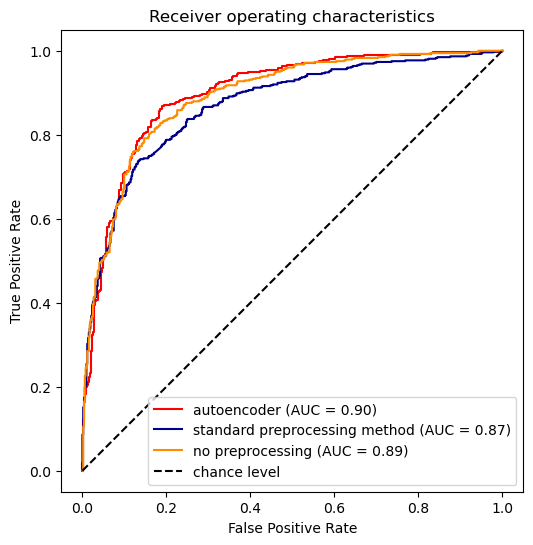

In [24]:
#sklearn.metrics.roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))

roc_autoencoder = RocCurveDisplay(fpr = fpr_autoencoder, 
                                  tpr = tpr_autoencoder, 
                                  roc_auc= auc_autoencoder, 
                                  estimator_name="autoencoder")

roc_autoencoder.plot(color="red", ax=ax)

roc_std = RocCurveDisplay(fpr = fpr_std,
                          tpr = tpr_std,
                          roc_auc = auc_std, 
                          estimator_name="standard preprocessing method")

roc_std.plot(color="darkblue", ax=ax)

roc_nopreprocessing = RocCurveDisplay(fpr = fpr_nopreprocessing,
                                      tpr = tpr_nopreprocessing, 
                                      roc_auc= auc_nopreprocessing, 
                                      estimator_name="no preprocessing")

roc_nopreprocessing.plot(color="darkorange", ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristics")
plt.legend()
plt.show()


Methodisches Problem: Train set hängt vom Testset ab, da daraus generiert.

In vorigen Tests war AUC von der standard methode 0.88